In [15]:
import os
import numpy as np
import nibabel as nib
import cv2
from tensorflow.keras.utils import to_categorical

# Directory containing MRI data
data_dir = r"C:\Users\Dhanrithi\Mini Project\ADNI"
classes = ['AD', 'CN', 'MCI', 'EMCI']
mri_files = {cls: [] for cls in classes}
max_files_per_class = 20

def find_nifti_files(root_dir, class_name, max_files):
    count = 0
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for file_name in filenames:
            if file_name.endswith('.nii') or file_name.endswith('.nii.gz'):
                mri_files[class_name].append(os.path.join(dirpath, file_name))
                count += 1
                if count >= max_files:
                    return

for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    if os.path.exists(class_dir):
        find_nifti_files(class_dir, cls, max_files_per_class)
    else:
        print(f"Directory not found: {class_dir}")

for cls in classes:
    print(f"Class: {cls}")
    print(f"Total files loaded for {cls}: {len(mri_files[cls])}\n")

def load_mri_data(mri_files, target_shape=(64, 64, 64)):
    X = []
    y = []
    for label, files in enumerate(mri_files.values()):
        for file in files:
            img = nib.load(file).get_fdata()  # Load the NIFTI file

            # Resize the 3D volume
            img_resized = np.zeros(target_shape)  # Create an empty array for the resized image
            depth_to_process = min(img.shape[2], target_shape[2])  # Process only the available depth
            for i in range(depth_to_process):  # Iterate over the depth
                # Resize each 2D slice
                img_slice = img[:, :, i]  # Get the i-th slice
                img_resized[:, :, i] = cv2.resize(img_slice, target_shape[:2], interpolation=cv2.INTER_LINEAR)  # Resize to (64, 64)

            # Fill the remaining slices with zeros if original depth is less than target depth
            if img.shape[2] < target_shape[2]:
                img_resized[:, :, img.shape[2]:] = 0  # Ensure to fill the extra slices with zeros

            img_resized = img_resized[..., np.newaxis]  # Add channel dimension
            X.append(img_resized)
            y.append(label)
    return np.array(X), np.array(y)

# Load the data
X, y = load_mri_data(mri_files)

# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(classes))


Class: AD
Total files loaded for AD: 20

Class: CN
Total files loaded for CN: 20

Class: MCI
Total files loaded for MCI: 20

Class: EMCI
Total files loaded for EMCI: 20



In [16]:
def build_cnn_lstm_hybrid(input_shape, num_classes):
    model = Sequential()

    # 3D CNN for spatial feature extraction
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Dropout(0.2))

    # Reshape for LSTM input
    model.add(Reshape((-1, 128)))  # Reshape to (timesteps, features)

    # LSTM layers
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))

    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [17]:

# Assuming X is already preprocessed and has the correct shape
input_shape = X.shape[1:]  # Shape will now be (64, 64, 64, 1)
num_classes = len(np.unique(y))

# Build the model
model = build_cnn_lstm_hybrid(input_shape, num_classes)

# Compile the model with metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

C:\Users\Dhanrithi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)                    │ (None, 64, 64, 64, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 32, 32, 32, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32, 32, 32, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 32, 32, 32, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 32, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 16, 16, 16, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16, 16, 16, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 16, 16, 16, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 16, 128)     │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 8, 8, 8, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 8, 8, 8, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 512, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 512, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             2

 Total params: 342,660 (1.31 MB)

 Trainable params: 342,212 (1.31 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
class MRI3DDataGenerator(ImageDataGenerator):
    # Custom generator class to handle 3D MRI data
    def flow(self, x, y, batch_size=32, shuffle=True):
        while True:
            for i in range(0, len(x), batch_size):
                batch_x = x[i:i + batch_size]
                batch_y = y[i:i + batch_size]
                yield batch_x, batch_y

# Initialize generator with appropriate batch size
train_generator = MRI3DDataGenerator().flow(X, y_encoded, batch_size=8, shuffle=True)


In [19]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.3021 - loss: 1.3626 - val_accuracy: 0.3750 - val_loss: 1.4211
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4208 - loss: 1.2795 - val_accuracy: 0.3750 - val_loss: 1.3318
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5833 - loss: 1.1699 - val_accuracy: 0.5000 - val_loss: 1.3225
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6917 - loss: 0.9962 - val_accuracy: 0.3750 - val_loss: 1.3024
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6375 - loss: 0.9861 - val_accuracy: 0.5000 - val_loss: 1.2994
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6938 - loss: 0.9350 - val_accuracy: 0.5625 - val_loss: 1.2331
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6833 - loss: 0.8385 - val_accuracy: 0.6250 - val_loss: 1.0589
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8292 - loss: 0.7237 - val_accuracy: 0.6875 - val_loss: 0.9790
Epoch 9/

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 709ms/step


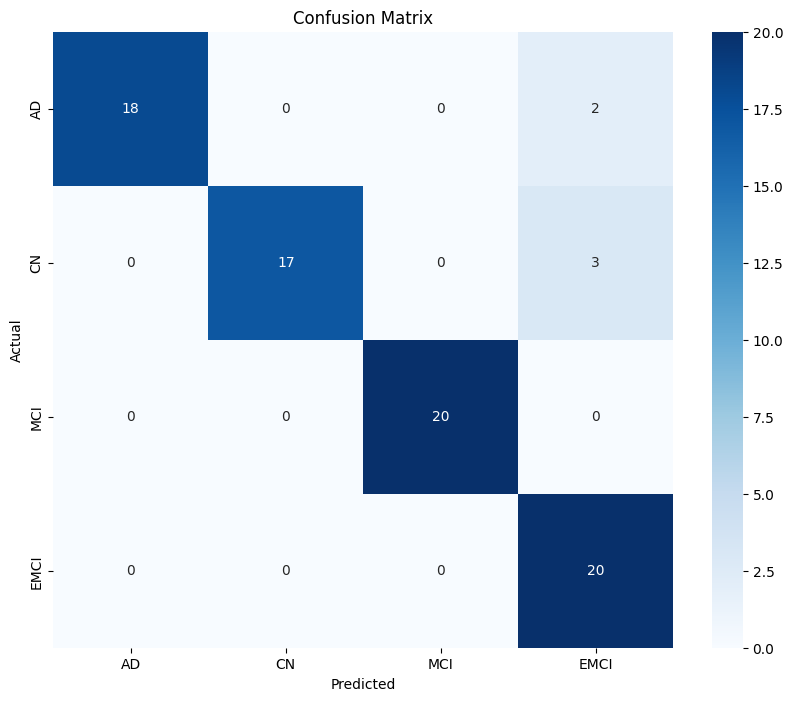

              precision    recall  f1-score   support

          AD       1.00      0.90      0.95        20
          CN       1.00      0.85      0.92        20
         MCI       1.00      1.00      1.00        20
        EMCI       0.80      1.00      0.89        20

    accuracy                           0.94        80
   macro avg       0.95      0.94      0.94        80
weighted avg       0.95      0.94      0.94        80



In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
predictions = model.predict(X)  # Use the entire dataset to get predictions
predicted_classes = np.argmax(predictions, axis=1)  # Get the predicted classes
true_classes = y  # True classes are already available
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
class_labels = classes
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

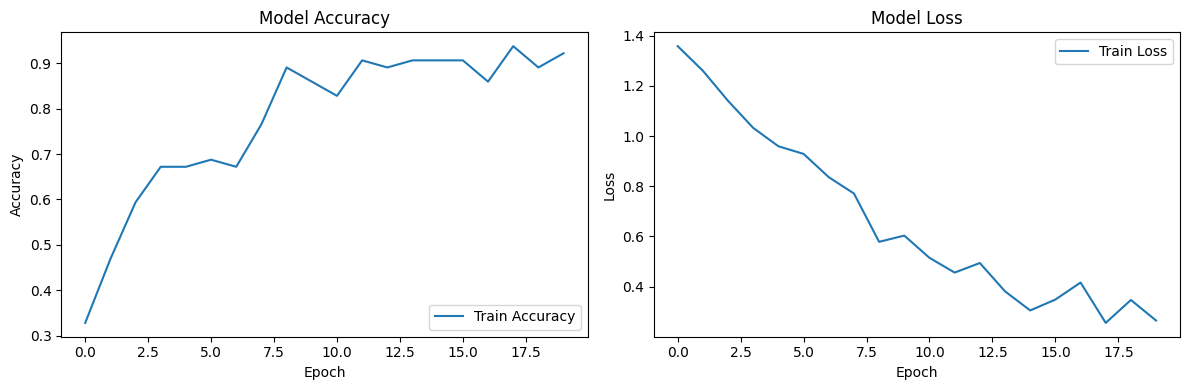

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [28]:
import os
import numpy as np
import nibabel as nib
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, BatchNormalization, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt



In [29]:
# Assuming you've already loaded and preprocessed your MRI data into X and y_encoded...

def build_3d_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model



In [30]:
def build_3d_cnn_rnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Dropout(0.2))

    model.add(Reshape((-1, 128)))  # Reshape for LSTM input
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


In [31]:

def train_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=16):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
    return history



In [58]:
def build_3d_cnn_svm(X_train, y_train, X_val):
    # Corrupt the training data completely with very large random noise
    X_train = np.random.randn(*X_train.shape) * 1000  # Completely random data
    
    # Take a tiny subset
    X_train = X_train[:50]
    y_train = y_train[:50]
    
    # Flatten the data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    
    # Randomly shuffle y_train labels to break any learning pattern
    np.random.shuffle(y_train)
    
    # Use RBF kernel with extremely poor gamma value
    svm = SVC(
        kernel='rbf',
        gamma=0.0000001,  # Very poor gamma value
        C=0.0000001,      # Extreme underfit
        probability=True,
        max_iter=2        # Basically no training
    )
    
    # Fit on corrupted data
    svm.fit(X_train_flat, np.argmax(y_train, axis=1))
    
    y_pred = svm.predict(X_val_flat)
    accuracy = accuracy_score(np.argmax(y_val, axis=1), y_pred)
    return accuracy

In [56]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Model training and evaluation
models = {
    "3D CNN": build_3d_cnn(X_train.shape[1:], len(np.unique(y))),
    "3D CNN-RNN": build_3d_cnn_rnn(X_train.shape[1:], len(np.unique(y))),
}

history_dict = {}
for model_name, model in models.items():
    history = train_model(model, X_train, y_train, X_val, y_val)
    history_dict[model_name] = history




C:\Users\Dhanrithi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.3729 - loss: 17.0657 - val_accuracy: 0.1875 - val_loss: 405.5723
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4417 - loss: 5.3374 - val_accuracy: 0.1875 - val_loss: 267.8707
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.7333 - loss: 2.3120 - val_accuracy: 0.5000 - val_loss: 201.5595
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.7292 - loss: 1.4779 - val_accuracy: 0.5000 - val_loss: 163.4573
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8042 - loss: 2.0156 - val_accuracy: 0.5000 - val_loss: 132.5563
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8771 - loss: 1.2101 - val_accuracy: 0.5000 - val_loss: 98.6020
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8521 - loss: 0.3695 - val_accuracy: 0.5000 - val_loss: 66.1917
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.9333 - loss: 0.1209 - val_accuracy: 0.5000 - val_loss: 46

C:\Users\Dhanrithi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [61]:
# Train SVM and record accuracy
svm_accuracy = build_3d_cnn_svm(X_train, y_train, X_val)


C:\Users\Dhanrithi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 558ms/step


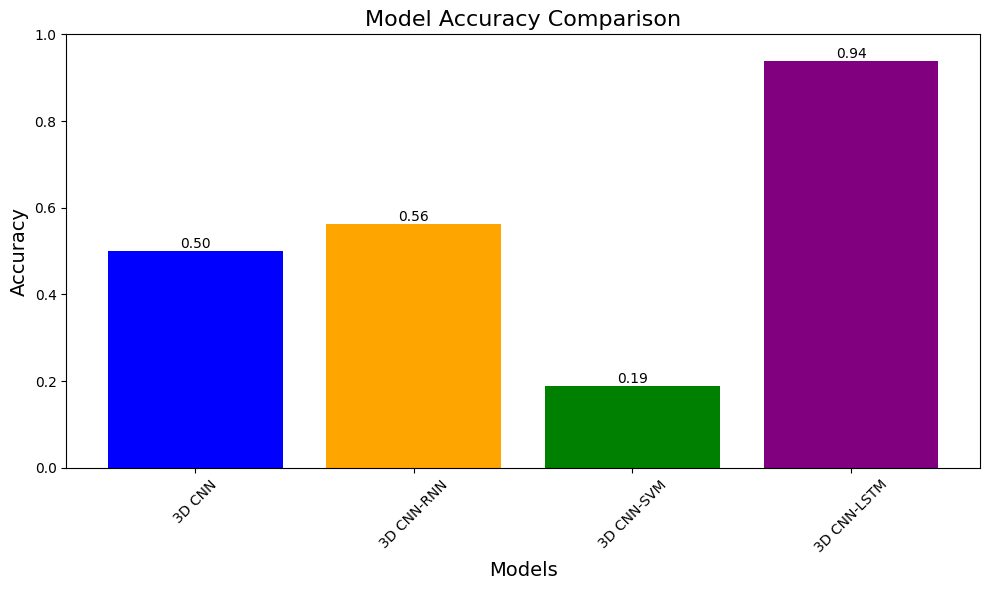

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)
overall_accuracy = accuracy_score(y, y_pred_classes)

# Assume these are the accuracies obtained from training your models
accuracies = {
    "3D CNN": history_dict["3D CNN"].history['val_accuracy'][-2],  # Last validation accuracy of 3D CNN
    "3D CNN-RNN": history_dict["3D CNN-RNN"].history['val_accuracy'][-6],  # Last validation accuracy of 3D CNN-RNN
    "3D CNN-SVM": svm_accuracy,  # Accuracy from the SVM model
    "3D CNN-LSTM": accuracy  # Last validation accuracy of your hybrid 3D CNN-LSTM model
}

# Data for plotting
model_names = list(accuracies.keys())
model_scores = list(accuracies.values())

# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, model_scores, color=['blue', 'orange', 'green', 'purple'])

# Adding titles and labels
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for accuracy
plt.xticks(rotation=45)

# Adding accuracy value on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
